## Dutch Housing Market Price Prediction - Model 

Imports

In [46]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Set consistent style for all visualizations
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['axes.grid'] = True
sns.set_theme(style="whitegrid")  # Set seaborn theme


Data Load

In [47]:
# Set random seed for reproducibility
np.random.seed(42)

# Load data
def load_data():
    """Load preprocessed training, validation, and test datasets."""
    X_train = pd.read_csv('../preprocessed_data/X_train.csv')
    X_val = pd.read_csv('../preprocessed_data/X_val.csv')
    X_test = pd.read_csv('../preprocessed_data/X_test.csv')
    y_train = pd.read_csv('../preprocessed_data/y_train.csv').values.ravel()
    y_val = pd.read_csv('../preprocessed_data/y_val.csv').values.ravel()
    y_test = pd.read_csv('../preprocessed_data/y_test.csv').values.ravel()
    
    print("Dataset sizes:")
    print(f"Training: {len(X_train)} samples")
    print(f"Validation: {len(X_val)} samples")
    print(f"Test: {len(X_test)} samples")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = load_data()

Dataset sizes:
Training: 3324 samples
Validation: 1109 samples
Test: 1109 samples


Model initialization and tuning

In [48]:
# Initialize models 
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Grid search 
param_grids = {
    'KNN': {'n_neighbors': [3, 5, 7, 9]},
    'Decision Tree': {'max_depth': [5, 10, 15, None]},
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    }
}

# Model tuning with cross-validation
print("Tuning models...")
tuned_models = {}
for name, model in models.items():
    if name in param_grids:
        print(f"\nTuning {name}...")
        grid_search = GridSearchCV(
            model, 
            param_grids[name],
            cv=5,
            scoring='neg_mean_squared_error',
            verbose=1
        )
        grid_search.fit(X_train, y_train)
        tuned_models[name] = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
    else:
        model.fit(X_train, y_train)
        tuned_models[name] = model

Tuning models...

Tuning KNN...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'n_neighbors': 3}

Tuning Decision Tree...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'max_depth': 5}

Tuning Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'max_depth': None, 'n_estimators': 100}


Evaluation

In [49]:
def evaluate_model(model, X_train, X_val, y_train, y_val):
    """
    Evaluate a model's performance on training and validation sets.
    Returns dictionary with RMSE and R² scores.
    """
    # Get predictions
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    # Calculate metrics
    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'val_rmse': np.sqrt(mean_squared_error(y_val, val_pred)),
        'train_r2': r2_score(y_train, train_pred),
        'val_r2': r2_score(y_val, val_pred),
        'train_mae': mean_absolute_error(y_train, train_pred),
        'val_mae': mean_absolute_error(y_val, val_pred)
    }
    
    return metrics

# Evaluate all models
results = {}
for name, model in tuned_models.items():
    print(f"\nEvaluating {name}...")
    model.fit(X_train, y_train)
    results[name] = evaluate_model(model, X_train, X_val, y_train, y_val)


Evaluating Linear Regression...

Evaluating KNN...

Evaluating Decision Tree...

Evaluating Random Forest...


Results Visualization

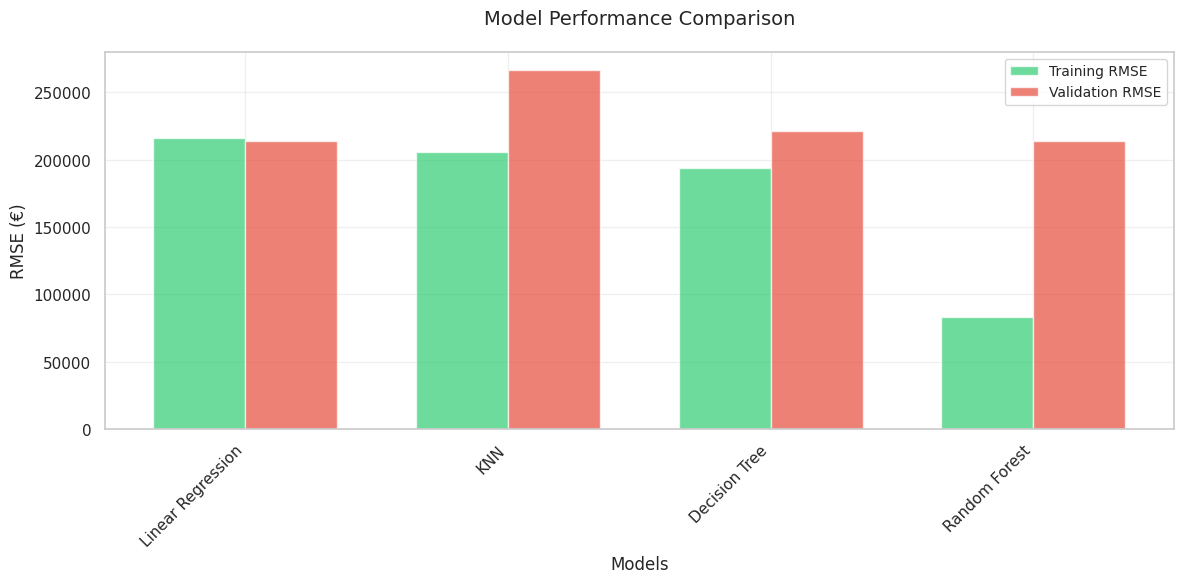


Detailed Model Performance:
--------------------------------------------------

Linear Regression:
Training RMSE: €215,876.31
Validation RMSE: €214,206.54
Training R²: 0.636
Validation R²: 0.588
Training MAE: €128,919.61
Validation MAE: €130,723.32

KNN:
Training RMSE: €206,152.01
Validation RMSE: €266,887.07
Training R²: 0.668
Validation R²: 0.361
Training MAE: €112,783.39
Validation MAE: €156,969.14

Decision Tree:
Training RMSE: €193,857.85
Validation RMSE: €221,135.64
Training R²: 0.706
Validation R²: 0.561
Training MAE: €121,405.00
Validation MAE: €131,865.87

Random Forest:
Training RMSE: €83,349.53
Validation RMSE: €213,908.53
Training R²: 0.946
Validation R²: 0.590
Training MAE: €46,547.43
Validation MAE: €123,241.41


In [50]:
# Cell 5: Results Visualization
def plot_model_comparison(results, metric='rmse'):
    """
    Create a professional bar plot comparing model performances.
    """
    plt.figure(figsize=(12, 6))
    x = np.arange(len(results))
    width = 0.35
    
    # Get metric values
    train_vals = [results[m][f'train_{metric}'] for m in results]
    val_vals = [results[m][f'val_{metric}'] for m in results]
    
    # Create bars
    plt.bar(x - width/2, train_vals, width, label=f'Training {metric.upper()}',
            color='#2ecc71', alpha=0.7)
    plt.bar(x + width/2, val_vals, width, label=f'Validation {metric.upper()}',
            color='#e74c3c', alpha=0.7)
    
    # Customize plot
    plt.xlabel('Models', fontsize=12)
    plt.ylabel(f'{metric.upper()} (€)', fontsize=12)
    plt.title('Model Performance Comparison', fontsize=14, pad=20)
    plt.xticks(x, list(results.keys()), rotation=45, ha='right')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

# Plot RMSE comparison
plot_model_comparison(results, 'rmse')
plt.show()

# Print detailed results
print("\nDetailed Model Performance:")
print("-" * 50)
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"Training RMSE: €{metrics['train_rmse']:,.2f}")
    print(f"Validation RMSE: €{metrics['val_rmse']:,.2f}")
    print(f"Training R²: {metrics['train_r2']:.3f}")
    print(f"Validation R²: {metrics['val_r2']:.3f}")
    print(f"Training MAE: €{metrics['train_mae']:,.2f}")
    print(f"Validation MAE: €{metrics['val_mae']:,.2f}")

Feature Importance Analysis


Feature Importance for Decision Tree:


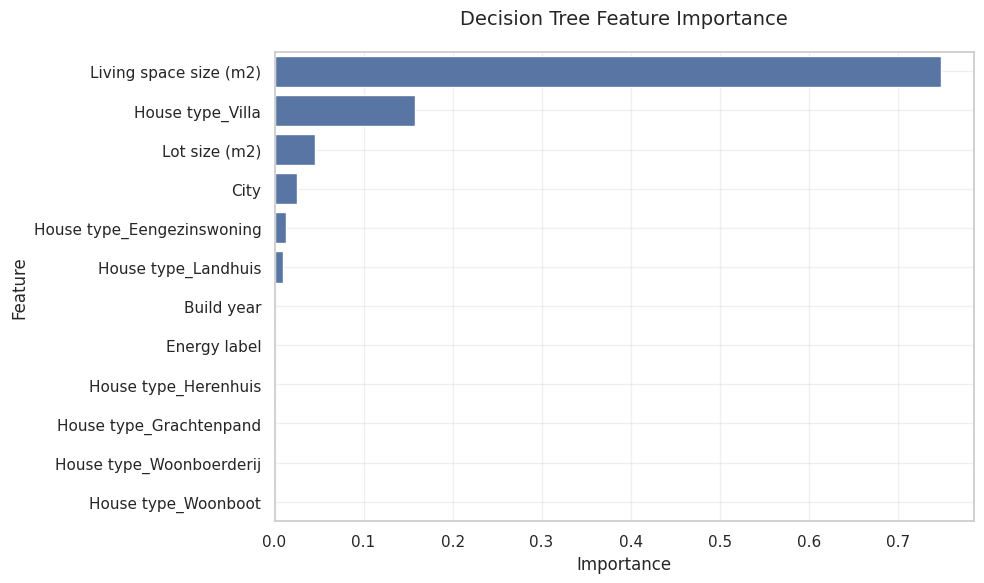


Feature Importance for Random Forest:


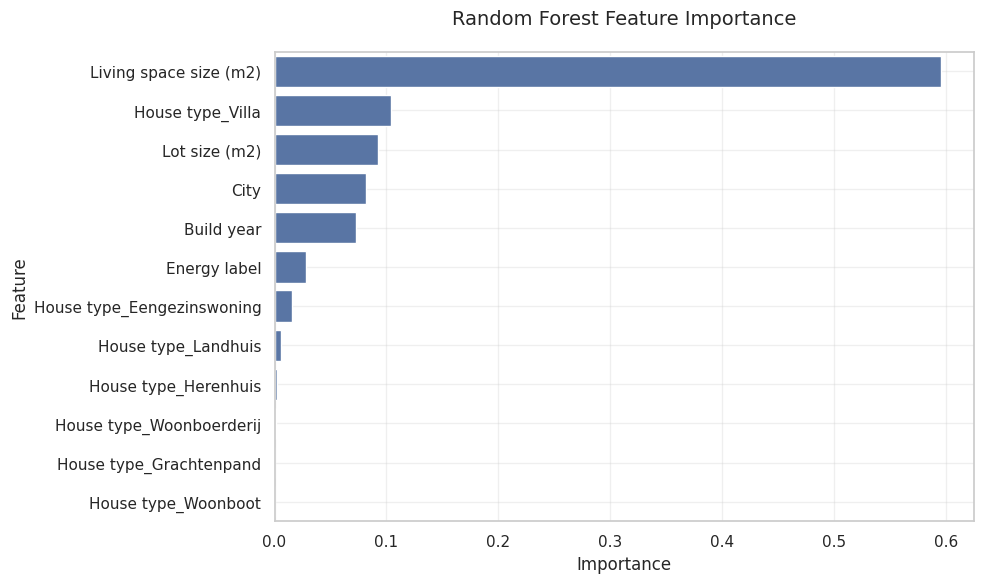

In [51]:
def plot_feature_importance(model, feature_names, title):
    """
    Plot feature importance for tree-based models.
    """
    if hasattr(model, 'feature_importances_'):
        importance = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=importance, x='importance', y='feature')
        plt.title(title, fontsize=14, pad=20)
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        return importance
    return None

# Plot feature importance for tree-based models
for name, model in tuned_models.items():
    if name in ['Decision Tree', 'Random Forest']:
        print(f"\nFeature Importance for {name}:")
        importance = plot_feature_importance(model, 
                                          X_train.columns, 
                                          f'{name} Feature Importance')
        plt.show()